<a href="https://colab.research.google.com/github/CRM48/AIML425-A2/blob/main/AllParts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Model 1, epoch 0, Loss: 0.7191
Model 1, epoch 500, Loss: 0.0067
Model 1, epoch 1000, Loss: 0.0132
Model 1, epoch 1500, Loss: 0.0042
Model 1, epoch 2000, Loss: 0.0072
Model 1, epoch 2500, Loss: 0.0165
Model 1, epoch 3000, Loss: 0.0032
Model 1, epoch 3500, Loss: 0.0045
Model 1, epoch 4000, Loss: 0.0119
Model 1, epoch 4500, Loss: 0.0057


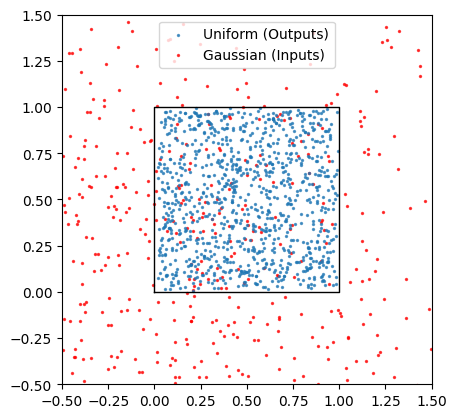

Model 2, epoch 0, Loss: 0.9570
Model 2, epoch 500, Loss: 0.0137
Model 2, epoch 1000, Loss: 0.0121
Model 2, epoch 1500, Loss: 0.0041
Model 2, epoch 2000, Loss: 0.0029
Model 2, epoch 2500, Loss: 0.0053
Model 2, epoch 3000, Loss: 0.0017
Model 2, epoch 3500, Loss: 0.0026
Model 2, epoch 4000, Loss: 0.0018
Model 2, epoch 4500, Loss: 0.0008


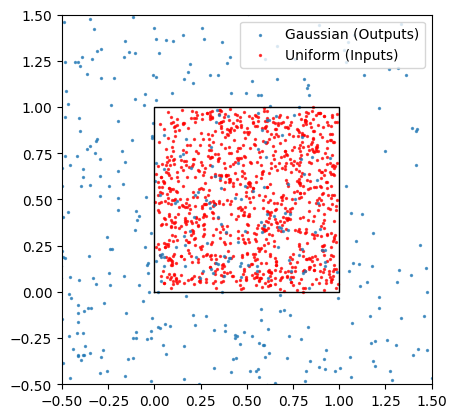

Model 3, epoch 0, Loss: 0.9455
Model 3, epoch 500, Loss: 0.0548
Model 3, epoch 1000, Loss: 0.0316
Model 3, epoch 1500, Loss: 0.0299
Model 3, epoch 2000, Loss: 0.0262
Model 3, epoch 2500, Loss: 0.0244
Model 3, epoch 3000, Loss: 0.0255
Model 3, epoch 3500, Loss: 0.0225
Model 3, epoch 4000, Loss: 0.0224
Model 3, epoch 4500, Loss: 0.0247


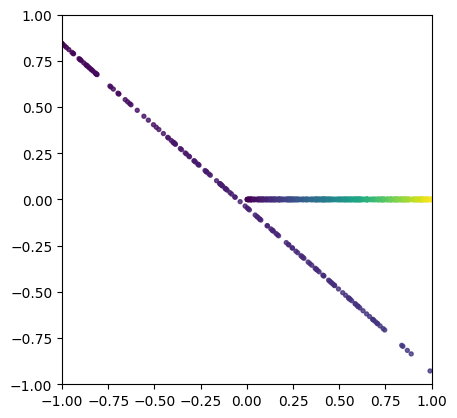

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

import torch
from torch import nn
import torch.optim as optim

# Model 1, 2D Gaussian to 2D uniform data
class ToUniformModel(nn.Module):
  def __init__(self, activation_function=nn.ReLU()):
    super(ToUniformModel, self).__init__()
    self.net = nn.Sequential(
         nn.Linear(2, 20),
         activation_function,
         nn.Linear(20, 20),
         activation_function,
         nn.Linear(20, 2),
         nn.Sigmoid() # Ensures data is between 0-1
     )

  def forward(self, x):
    return self.net(x)

# Model 2, 2D Uniform to 2D Gaussian data
class ToGaussianModel(nn.Module):
  def __init__(self, activation_function=nn.ReLU()):
    super(ToGaussianModel, self).__init__()
    self.net = nn.Sequential(
         nn.Linear(2, 50),
         activation_function,
         nn.Linear(50, 50),
         activation_function,
         nn.Linear(50, 50),
         activation_function,
         nn.Linear(50, 2) # Output is any real value
     )

  def forward(self, x):
    return self.net(x)

# Model 3, 1D Uniform to 2D Gaussian data
class OneDToGaussianModel(nn.Module):
  def __init__(self, activation_function=nn.ReLU()):
    super(OneDToGaussianModel, self).__init__()
    self.net = nn.Sequential(
         nn.Linear(1, 20),
         activation_function,
         nn.Linear(20, 20),
         activation_function,
         nn.Linear(20, 2)
     )

  def forward(self, x):
    return self.net(x)


# Computes pairwise Gaussian kernel between two sets of 2D vectors
def gaussian_kernel(x, y, sigma=0.2):
    # Add dimensions to allow for vector operations
    x_exp = x.unsqueeze(1)
    y_exp = y.unsqueeze(0)
    diff = x_exp - y_exp
    dist_sq = torch.sum(diff ** 2, dim=2)
    # Return exp((||x-y||^2) / (2σ^2))
    return torch.exp(-dist_sq / (2 * sigma ** 2))


# Calculates the maximum mean discrepancy loss
# Uses the Gaussian Kernal function above
def mmd_loss(x, y, sigma=0.2):
    Kxx = gaussian_kernel(x, x, sigma)
    Kyy = gaussian_kernel(y, y, sigma)
    Kxy = gaussian_kernel(x, y, sigma)
    ## Return output of mmd loss formula
    return Kxx.mean() + Kyy.mean() - 2 * Kxy.mean()


# Parameters
learning_rate = 0.001
num_epochs = 5000
batch_size = 256
lambda_val = 0.001
weight_distributions = {}

# Create model and optimizer for first model
uniform_model = ToUniformModel(nn.LeakyReLU())
uniform_optimizer = optim.Adam(uniform_model.parameters(), lr=learning_rate)

# Create model and optimizer for second model
gaussian_model = ToGaussianModel(nn.LeakyReLU())
gaussian_optimizer = optim.Adam(gaussian_model.parameters(), lr=learning_rate)

# Create model and optimizer for third model
oned_gaussian_model = OneDToGaussianModel(nn.LeakyReLU())
oned_gaussian_optimizer = optim.Adam(oned_gaussian_model.parameters(), lr=learning_rate)

# Training for first model, can add regularisations for testing
# Currently only none is used, so just base loss will be used to train
for reg_type in ["none"]:
  # Create new model for each regularisation type
  uniform_model = ToUniformModel(nn.LeakyReLU())
  uniform_optimizer = optim.Adam(uniform_model.parameters(), lr=learning_rate)

  for epoch in range(num_epochs):
      # Generate inputs, predictions and uniform distribution
      normal = torch.randn(batch_size, 2)
      uniform = torch.rand(batch_size, 2)
      predictions = uniform_model(normal)

      # Generate base loss
      loss = mmd_loss(predictions, uniform, sigma=0.2)

      # Penalties
      if reg_type == "l1":
        l1_penalty = sum(p.abs().sum() for p in uniform_model.parameters())
        loss += lambda_val * l1_penalty

      if reg_type == "l2":
        l2_penalty = sum((p**2).sum() for p in uniform_model.parameters())
        loss += lambda_val * l2_penalty


      # Backpropogate
      uniform_optimizer.zero_grad()
      loss.backward()
      uniform_optimizer.step()


      if epoch % 500 == 0:
        print(f"Model 1, epoch {epoch}, Loss: {loss.item():.4f}")

  # After training, store weights for visualization
  all_weights = torch.cat([p.flatten() for p in uniform_model.parameters()]).detach().numpy()
  weight_distributions[reg_type] = all_weights

# Compare weight distributions of regularisation types

"""
colors = ["#0072B2", "#E69F00", "#CC79A7"]
count = 0
plt.figure(figsize=(8, 5))
for reg_type, weights in weight_distributions.items():
    kde = gaussian_kde(weights)
    x_vals = np.linspace(min(weights), max(weights), 200)
    plt.plot(x_vals, kde(x_vals), color=colors[count], label=reg_type, linewidth=2, zorder=count)
    count += 1

plt.title(f"Weight distributions using different regularizations at lambda {lambda_val}")
plt.xlabel("Weight value")
plt.yticks([])
plt.legend()
plt.show()
"""

# Generate predictions using final model
with torch.no_grad():
    normal = torch.randn(1000, 2)
    predictions = uniform_model(normal)

# Plot uniform outputs of model compared to normal distributed inputs
plt.scatter(predictions[:,0], predictions[:,1], label='Uniform (Outputs)', s=2, alpha=0.7, zorder=2)
plt.scatter(normal[:,0], normal[:,1], label='Gaussian (Inputs)', color='red', s=2, alpha=0.7, zorder=1)

plt.plot([0,1,1,0,0], [0,0,1,1,0], color='black', linewidth=1)
plt.xlim(-0.5, 1.5)
plt.ylim(-0.5, 1.5)
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.show()


# Training for model 2
for epoch in range(num_epochs):
    # Generate gaussian data, paired uniform data, and predicted data
    normal = torch.randn(batch_size, 2)
    uniform = uniform_model(normal).detach()
    predictions = gaussian_model(uniform)

    # Compute loss comparing predictions to paired gaussian data
    loss = nn.MSELoss()(predictions, normal)

    # Backpropogate
    gaussian_optimizer.zero_grad()
    loss.backward()
    gaussian_optimizer.step()

    if epoch % 500 == 0:
      print(f"Model 2, epoch {epoch}, Loss: {loss.item():.4f}")

# Generate predictions of final model
with torch.no_grad():
    normal = torch.randn(1000, 2)
    uniform = uniform_model(normal)
    predictions = gaussian_model(uniform)

# Plot gaussian outputs of model compared to uniformly distributed inputs
plt.scatter(predictions[:,0], predictions[:,1], label='Gaussian (Outputs)', s=2, alpha=0.7, zorder=2)
plt.scatter(uniform[:,0], uniform[:,1], label='Uniform (Inputs)', color='red', s=2, alpha=0.7, zorder=1)

plt.plot([0,1,1,0,0], [0,0,1,1,0], color='black', linewidth=1)
plt.xlim(-0.5, 1.5)
plt.ylim(-0.5, 1.5)
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.show()

# Training for model 3
for epoch in range(num_epochs):
    # Generate inputs, uniform distribution, and predictions (using uniform)
    normal = torch.randn(batch_size, 2)
    uniform = torch.rand(batch_size, 1)
    predictions = oned_gaussian_model(uniform)

    # Generate loss
    loss = loss = mmd_loss(predictions, normal, sigma=0.2)

    # Backpropogate
    oned_gaussian_optimizer.zero_grad()
    loss.backward()
    oned_gaussian_optimizer.step()

    if epoch % 500 == 0:
      print(f"Model 3, epoch {epoch}, Loss: {loss.item():.4f}")


# Generate predictions using final model
with torch.no_grad():
    uniform = torch.rand(1000, 1)
    predictions = oned_gaussian_model(uniform)

colors = uniform[:, 0]

plt.scatter(predictions[:, 0], predictions[:, 1], c=colors, cmap='viridis', s=8, alpha=0.8, zorder=2)
plt.scatter(uniform[:, 0], torch.zeros_like(uniform[:, 0]), c=colors, cmap='viridis', s=8, alpha=0.8, zorder=1)

plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()